In [1]:
import pandas as pd
import numpy as np
# roc curve and auc on an imbalanced dataset
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Creating Prediction Dataframe and calculating probabilities  

In [2]:
# Reading path
inport_file_path = 'csv/testing/xgboost_pred_rapidminer.csv'

# Export path
export_file_path = 'csv/testing/xgboost_probability.csv'

In [3]:
"""
Creating the prediction csv file
"""
# CSV file
df_classifier = pd.read_csv(inport_file_path)

# Create the ID column by concatenating the values of 'subject_id', 'hadm_id'
df_classifier['subject_&_hadm'] = df_classifier['subject_id'].astype(str) + df_classifier['hadm_id'].astype(str)


# Create column propability of alive (1 for alive 0 for death)
df_classifier['Propability_of_alive'] = df_classifier['prediction(hospital_expire_flag)'].apply(lambda x: 1 if x == 0 else 0)

# Create column propability of death 1 for death 0 for alive
df_classifier['Propability_of_death'] = df_classifier['prediction(hospital_expire_flag)'].apply(lambda x: 1 if x == 1 else 0)

# Replace 0 with 1 and 1 with 0 in the 'hospital_expire_flag' column and rename the column
df_classifier['hospital_expire_flag'] = df_classifier['hospital_expire_flag'].replace({0: 1, 1: 0})
df_classifier = df_classifier.rename(columns={'hospital_expire_flag': 'Ground_Truth_Alive'})

# Remove the 'prediction(hospital_expire_flag)' column
df_classifier = df_classifier.drop(columns=['prediction(hospital_expire_flag)'])

In [4]:
"""
Calculate the probability of Alive and Death
"""

# Create a new column 'denominator' that counts for each 'subject_&_hadm'
df_classifier['Denominator'] = df_classifier.groupby('subject_&_hadm').cumcount() + 1

# Create a new column 'numerator' based on the conditions
df_classifier['Numerator'] = df_classifier.groupby('subject_&_hadm')['Propability_of_alive'].transform(lambda x: x.cumsum() if x.iloc[0] == 1 else x.cumsum() - 1).fillna(0)


# Probability of Alive
df_classifier['Probability_of_Alive'] = df_classifier['Numerator'] / df_classifier['Denominator']

# Probability of Death
df_classifier['Probability_of_Death'] = 1 - df_classifier['Probability_of_Alive']


# Repositioning the columns in the DataFrame
columns_to_move = ['subject_&_hadm', 'subject_id', 'hadm_id', 'Time_Zone',
                   'Propability_of_alive', 'Propability_of_death',
                   'Ground_Truth_Alive', 'Numerator','Denominator',
                   'Probability_of_Alive', 'Probability_of_Death']
df_classifier = df_classifier[columns_to_move + [col for col in df_classifier.columns if col not in columns_to_move]]


# Export to csv
df_classifier.to_csv(export_file_path, index=False)

In [5]:
display(df_classifier)

,subject_&_hadm,subject_id,hadm_id,Time_Zone,Propability_of_alive,Propability_of_death,Ground_Truth_Alive,Numerator,Denominator,Probability_of_Alive,Probability_of_Death,confidence(0),confidence(1),row_count
0,1699821925992447,16998219,25992447,1,1,0,1,1,1,1.0,0.0,0.913975,0.086025,1
1,1699821925992447,16998219,25992447,2,1,0,1,2,2,1.0,0.0,0.913975,0.086025,2
2,1699821925992447,16998219,25992447,3,1,0,1,3,3,1.0,0.0,0.913975,0.086025,3
3,1699821925992447,16998219,25992447,4,1,0,1,4,4,1.0,0.0,0.925911,0.074089,4
4,1699821925992447,16998219,25992447,5,1,0,1,5,5,1.0,0.0,0.925911,0.074089,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16747,1999998723865745,19999987,23865745,12,1,0,1,12,12,1.0,0.0,0.960095,0.039905,16748
16748,1999998723865745,19999987,23865745,13,1,0,1,13,13,1.0,0.0,0.965121,0.034879,16749
16749,1999998723865745,19999987,23865745,14,1,0,1,14,14,1.0,0.0,0.960095,0.039905,16750
16750,1999998723865745,19999987,23865745,15,1,0,1,15,15,1.0,0.0,0.965121,0.034879,16751


# Creating ROC Diagrams

In [6]:
# Variables
algorithm_label = 'XGBoost'
xlabel = 'False Positive Rate'
ylabel = 'True Positive Rate'

"""
Ανάθεση σε μεταβλητές των στοιχείων του πίνακα του 
πρώτου 3ωρου, 6ωρου, 12ωρου και 24ώρου.
"""
hour1 = df_classifier.loc[df_classifier['Denominator'] == 1]
hour2 = df_classifier.loc[df_classifier['Denominator'] == 2]
hour3 = df_classifier.loc[df_classifier['Denominator'] == 4]
hour4 = df_classifier.loc[df_classifier['Denominator'] == 8]

"""
Ανάθεση σε μεταβλητές της στήλης Ground Truth Alive της
κάθε ώρας και μετατροπή της από dataframe σε list.
"""

ground_truth_alive1 = hour1["Ground_Truth_Alive"].tolist()
ground_truth_alive2 = hour2["Ground_Truth_Alive"].tolist()
ground_truth_alive3 = hour3["Ground_Truth_Alive"].tolist()
ground_truth_alive4 = hour4["Ground_Truth_Alive"].tolist()

"""
Ανάθεση σε μεταβλητές της στήλης Prob - Alive της κάθε μέρας και
μετατροπή της από dataframe σε list.
"""

prob_alive1 = hour1["Probability_of_Alive"].tolist()
prob_alive2 = hour2["Probability_of_Alive"].tolist()
prob_alive3 = hour3["Probability_of_Alive"].tolist()
prob_alive4 = hour4["Probability_of_Alive"].tolist()

"""
Ανάθεση σε μεταβλητές της στήλης Prob - Dead της κάθε μέρας και
μετατροπή της από dataframe σε list.
"""

prob_dead1 = hour1["Probability_of_Death"].tolist()
prob_dead2 = hour2["Probability_of_Death"].tolist()
prob_dead3 = hour3["Probability_of_Death"].tolist()
prob_dead4 = hour4["Probability_of_Death"].tolist()

#Ground Truth Dead ανά ημέρα
"""
Για την δημιουργία του Ground Truth Dead ανά ημέρα, αφαιρώ από
την ground_truth_alive της κάθε μέρας το 1 και με την χρήση της
abs παίρνω την απόλυτη τιμή της. Έτσι έχω τις τιμές χωρίς πρόσιμο.
Με αυτή τη διεργασία οι τιμές της Ground Truth Alive και Ground
Truth Dead είναι αντεστραμένες.
"""

#Day 1
ground_truth_dead1=abs(np.subtract(ground_truth_alive1, 1))

#Day 2
ground_truth_dead2=abs(np.subtract(ground_truth_alive2, 1))

#Day 3
ground_truth_dead3=abs(np.subtract(ground_truth_alive3, 1))

#Day 4
ground_truth_dead4=abs(np.subtract(ground_truth_alive4, 1))

AUC =  0.8017360008468297
Thresholds           [inf  1. -1.]
False Possitive Rate [0.        0.3681592 1.       ]
False Possitive Rate [0.         0.97163121 1.        ]


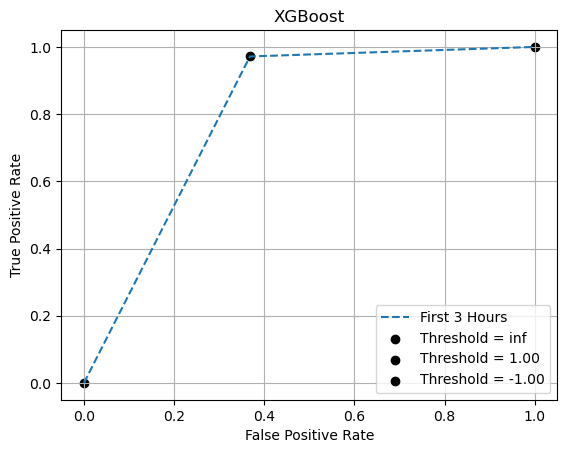

In [7]:
# Your existing code for ROC curve
print("AUC = ", roc_auc_score(ground_truth_alive1, prob_alive1))
fpr1, tpr1, thresholds1 = roc_curve(ground_truth_alive1, prob_alive1)
pyplot.plot(fpr1, tpr1, linestyle='--', label='First 3 Hours')

# Scatter plot for thresholds
for i, threshold in enumerate(thresholds1):
    pyplot.scatter(fpr1[i], tpr1[i], marker='o', color='black', label=f'Threshold = {threshold:.2f}')

pyplot.xlabel(xlabel)
pyplot.ylabel(ylabel)
pyplot.legend()
pyplot.grid(True)
pyplot.title(algorithm_label)

print("Thresholds          ", thresholds1)
print("False Possitive Rate", fpr1)
print("False Possitive Rate", tpr1)

# Save the plot in high resolution (adjust the dpi as needed)
plt.savefig('plots/roc_3hour_plot.png', dpi=300)

# Show the plot
pyplot.show()

AUC =  0.8048292814885384
Thresholds           [ inf  1.   0.5  0.  -0.5]
False Possitive Rate [0.         0.36318408 0.3681592  0.37313433 1.        ]
False Possitive Rate [0.         0.97163121 0.97163121 0.97399527 1.        ]


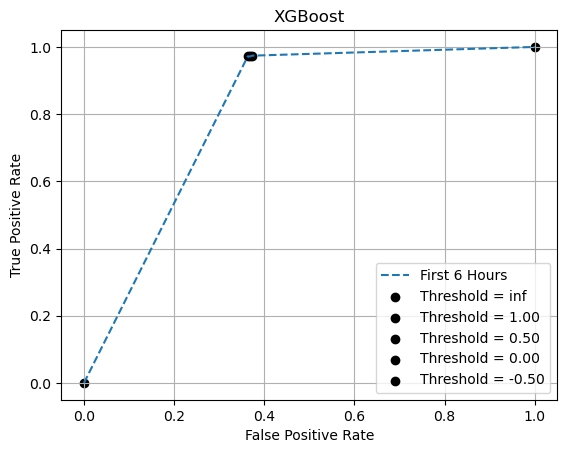

In [8]:
print("AUC = ", roc_auc_score(ground_truth_alive2, prob_alive2))
fpr2, tpr2, thresholds2 = roc_curve(ground_truth_alive2, prob_alive2)
pyplot.plot(fpr2, tpr2, linestyle='--', label='First 6 Hours')

# Scatter plot for thresholds
for i, threshold in enumerate(thresholds2):
    pyplot.scatter(fpr2[i], tpr2[i], marker='o', color='black', label=f'Threshold = {threshold:.2f}')

pyplot.xlabel(xlabel)
pyplot.ylabel(ylabel)
pyplot.legend()
pyplot.grid(True)
pyplot.title(algorithm_label)

print("Thresholds          ", thresholds2)
print("False Possitive Rate", fpr2)
print("False Possitive Rate", tpr2)

# Save the plot in high resolution (adjust the dpi as needed)
plt.savefig('plots/roc_6hour_plot.png', dpi=300)

# Show the plot
pyplot.show()

AUC =  0.8130564670736153
Thresholds           [  inf  1.    0.75  0.25  0.   -0.25]
False Possitive Rate [0.         0.34825871 0.35323383 0.37313433 0.3880597  1.        ]
False Possitive Rate [0.         0.97163121 0.97163121 0.97635934 0.97754137 1.        ]


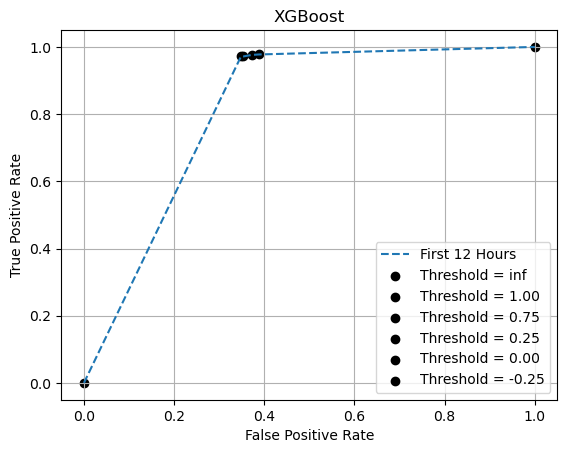

In [9]:
print("AUC = ", roc_auc_score(ground_truth_alive3, prob_alive3))
fpr3, tpr3, thresholds3 = roc_curve(ground_truth_alive3, prob_alive3)
pyplot.plot(fpr3, tpr3, linestyle='--', label='First 12 Hours')

# Scatter plot for thresholds
for i, threshold in enumerate(thresholds3):
    pyplot.scatter(fpr3[i], tpr3[i], marker='o', color='black', label=f'Threshold = {threshold:.2f}')

pyplot.xlabel(xlabel)
pyplot.ylabel(ylabel)
pyplot.legend()
pyplot.grid(True)
pyplot.title(algorithm_label)

print("Thresholds          ", thresholds3)
print("False Possitive Rate", fpr3)
print("False Possitive Rate", tpr3)

# Save the plot in high resolution (adjust the dpi as needed)
plt.savefig('plots/roc_12hour_plot.png', dpi=300)

# Show the plot
pyplot.show()

AUC =  0.8192371475953566
Thresholds           [   inf  1.     0.875  0.75   0.625  0.5    0.375  0.25   0.125  0.
 -0.125]
False Possitive Rate [0.         0.33830846 0.33830846 0.33830846 0.34328358 0.35820896
 0.37810945 0.39303483 0.40298507 0.41791045 1.        ]
False Possitive Rate [0.         0.96808511 0.96926714 0.97399527 0.97399527 0.9751773
 0.97635934 0.97990544 0.98345154 0.98463357 1.        ]


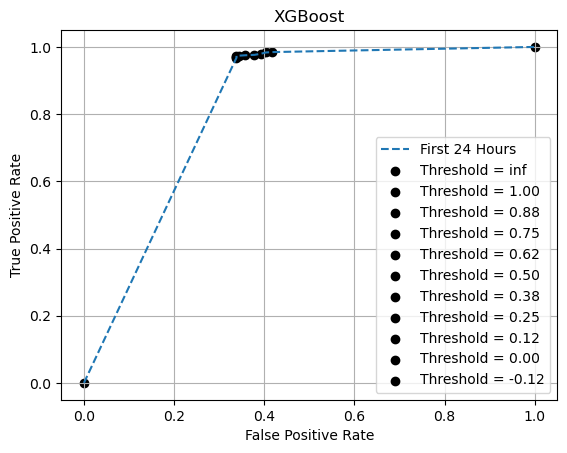

In [10]:
print("AUC = ", roc_auc_score(ground_truth_alive4, prob_alive4))
fpr4, tpr4, thresholds4 = roc_curve(ground_truth_alive4, prob_alive4)
pyplot.plot(fpr4, tpr4, linestyle='--', label='First 24 Hours')

# Scatter plot for thresholds
for i, threshold in enumerate(thresholds4):
    pyplot.scatter(fpr4[i], tpr4[i], marker='o', color='black', label=f'Threshold = {threshold:.2f}')

pyplot.xlabel(xlabel)
pyplot.ylabel(ylabel)
pyplot.legend()
pyplot.grid(True)
pyplot.title(algorithm_label)

print("Thresholds          ", thresholds4)
print("False Possitive Rate", fpr4)
print("False Possitive Rate", tpr4)

# Save the plot in high resolution (adjust the dpi as needed)
plt.savefig('plots/roc_24hour_plot.png', dpi=300)

# Show the plot
pyplot.show()

## Alive

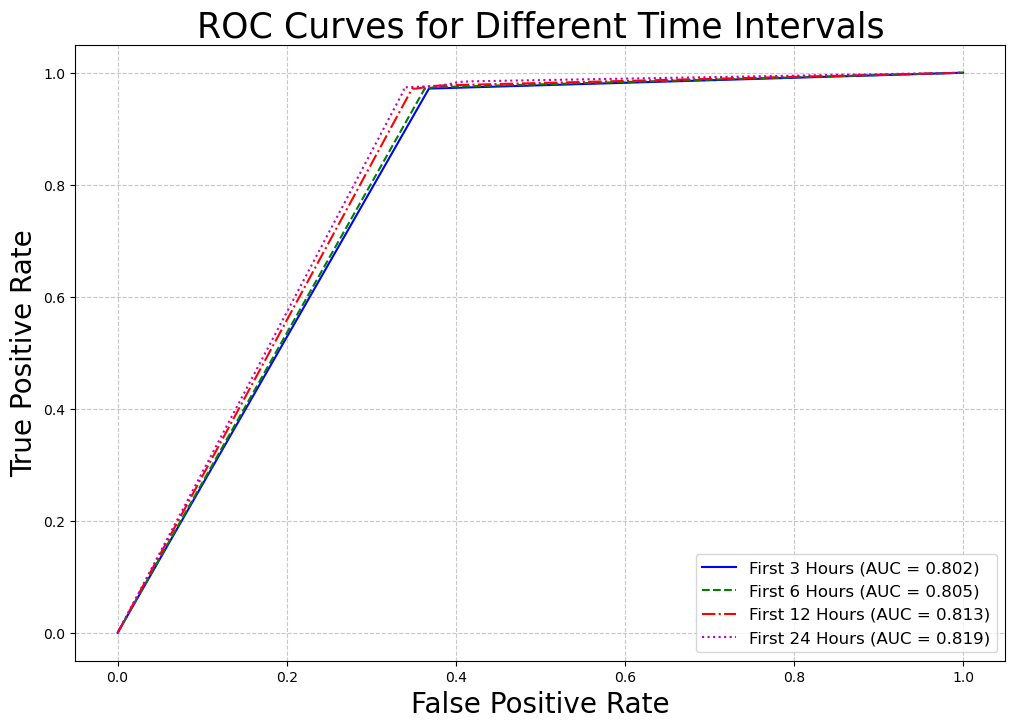

In [11]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Calculate AUC scores
auc_3_hours = roc_auc_score(ground_truth_alive1, prob_alive1)
auc_6_hours = roc_auc_score(ground_truth_alive2, prob_alive2)
auc_12_hours = roc_auc_score(ground_truth_alive3, prob_alive3)
auc_24_hours = roc_auc_score(ground_truth_alive4, prob_alive4)

# Create a plot
plt.figure(figsize=(12, 8))

# Plot ROC curves with different line styles and colors
plt.plot(fpr1, tpr1, linestyle='-', color='b', label=f'First 3 Hours (AUC = {auc_3_hours:.3f})')
plt.plot(fpr2, tpr2, linestyle='--', color='g', label=f'First 6 Hours (AUC = {auc_6_hours:.3f})')
plt.plot(fpr3, tpr3, linestyle='-.', color='r', label=f'First 12 Hours (AUC = {auc_12_hours:.3f})')
plt.plot(fpr4, tpr4, linestyle=':', color='m', label=f'First 24 Hours (AUC = {auc_24_hours:.3f})')

# Customize the plot
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.legend(fontsize=12, loc='best')
plt.grid(linestyle='--', alpha=0.7)
plt.title('ROC Curves for Different Time Intervals', fontsize=25)

# Save the plot in high resolution (adjust the dpi as needed)
plt.savefig('plots/roc_pivot_plot.png', dpi=300)

# Show the plot
plt.show()